In [1]:
#import tensorflow and enable eager excution for debugging
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from glob import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import time
from tensorflow.keras import layers

# import helper functions
import helper

from IPython import display

In [3]:
# set up status if data needed preprocess or load trained model
do_preprocess = False
load_checkpoint = False

### reize image to 128 by 128 if do_preprocess set to True

In [4]:
data_dir = './data'
data_resized_dir = './resized_data'

if do_preprocess == True:
    os.mkdir(data_resized_dir)
    
    for each in os.listdir(data_dir):
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(os.path.join(data_resized_dir, each), image)

### display input images, explore the input data

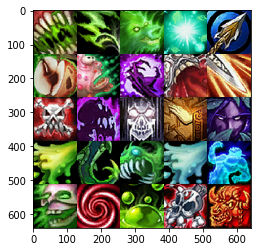

In [5]:
# numbers of images to display as grid
n_to_display = 5 * 5

images = helper.get_batch(glob(os.path.join(data_resized_dir, '*.png'))[:n_to_display], 64, 64, 'RGB')
plt.imshow(helper.images_to_grid(images, 'RGB'))

In [6]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024) # Note: None is the batch size
    
    # conv 1 _ 16 x 16 x 512
    model.add(layers.Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 512)  
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
    
    # conv 2 _ 32 x 32 x 256
    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)  
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
    
    # conv 3 _ 64 x 64 x 128
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128) 
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
    
    # conv 4 _ 128 x 128 x 64
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64) 
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())    
    
    # conv 5 _ 128 x 128 x 3
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3) 
    
    return model

In [7]:
# display generator model as graph
generator = generator_model()
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       13107200  
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16, 16, 512)       2048      
_________________________________________________________________
leak

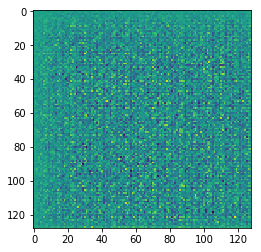

In [8]:
random_noise= tf.random_normal([4 * 4, 100])

generated_image = generator(random_noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [65]:
def discriminator_model():
    model = tf.keras.Sequential()
    
    # conv 1 128 x 128 x 3 --> 64 x 64 x 64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))
    
    # conv 2 64 x 64 x 64 --> 32 x 32 x 128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))
    
    # conv 3 32 x 32 x 128 --> 16 x 16 x 256
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

    # conv 4 16 x 16 x 256 --> 16 x 16 x 512
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

    # conv 5 16 x 16 x 512 --> 8 x 8 x 1024
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [66]:
discriminator = discriminator_model()
decision = discriminator(generated_image)

In [11]:
# test discriminator model, low values as the generator is not trained
print(decision)

tf.Tensor(
[[-8.7037821e-05]
 [-1.1162374e-04]
 [-1.4037451e-04]
 [-7.8713107e-05]
 [-9.8735851e-05]
 [-9.6589545e-05]
 [-6.2430088e-05]
 [-1.4895292e-04]
 [-1.1292965e-04]
 [-1.0578366e-04]
 [-1.2110481e-04]
 [-1.0493549e-04]
 [-9.8707867e-05]
 [-8.0875965e-05]
 [-1.1515314e-05]
 [-1.3800747e-04]], shape=(16, 1), dtype=float32)


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate = .00005, beta1 = 0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate = 2e-4, beta1 = 0.5)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [72]:
EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 4 * 4

# seeding generator with random noise each epoch
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [ ]:
# EPOCHS = 10
# noise_dim = 100
# num_examples_to_generate = 6

# # seeding generator with random noise each epoch
# random_vector_for_generation = tf.random_normal([num_examples_to_generate,
#                                                  noise_dim])

In [56]:
random_vector_for_generation.shape

TensorShape([Dimension(9), Dimension(100)])

In [42]:
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
        
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
        
        Gen_losse_num = gen_loss.numpy()
        Disc_losse_mum = disc_loss.numpy()
        
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
    
      return Gen_losse_num, Disc_losse_mum

In [20]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
def train(dataset, epochs):
    Gen_losses = []
    Dis_losses = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for images in dataset:
              
            Gen_loss, Dis_loss = train_step(images)            
            Gen_losses.append(Gen_loss)
            Dis_losses.append(Dis_loss)
            
            display.clear_output(wait=True)
            generate_and_save_images(generator,epoch + 1,random_vector_for_generation)

            print('At epoch {} ,Gen-loss is {} , Dis-loss is {} '.format(epoch + 1, Gen_loss, Dis_loss))
            
        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        
    # Generate after the final epoch    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             random_vector_for_generation)
    
    return Gen_losses, Dis_losses

In [79]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = predictions.numpy()
    predictions = helper.images_to_grid(predictions, 'RGB')
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(predictions)
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### load & process the image into tensors

In [80]:
train_images = helper.get_batch(glob(os.path.join(data_resized_dir, '*.png')), 128, 128, 'RGB')
train_images.shape

(1015, 128, 128, 3)

In [81]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print('The tensor value is between {} and {} after normalization'.format(train_images.min(), train_images.max()))

The tensor value is between -1.0 and 1.0 after normalization


In [82]:
BUFFER_SIZE = 10
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [83]:
# now the data set is ready
train_dataset

<DatasetV1Adapter shapes: (?, 128, 128, 3), types: tf.float32>

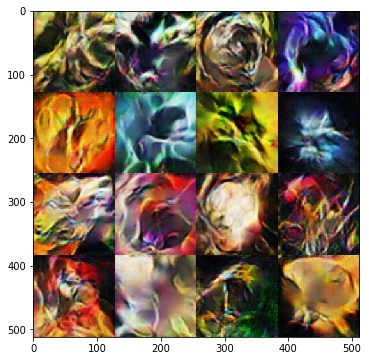

5.2040806
0.029291276


In [ ]:
%%time
G_losses, D_losses = train(train_dataset, EPOCHS)

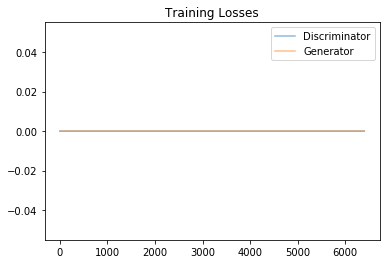

In [74]:
fig, ax = plt.subplots()
plt.plot(D_losses, label='Discriminator', alpha=0.5)
plt.plot(G_losses, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()